In [15]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

# Summarize results into Pandas DataFrame

In [16]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)

    return model_meta

In [29]:
model_meta = pd.DataFrame()

root_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'frozen',
                        'fixed_batch_size',
                        'fixed_valid_set',
                        'fine_tune_2topmost')
base_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'baseline',
                        'fixed_batch_size',
                        'variable_valid_set')
source_train_baseline_dir = os.path.join(base_dir, 'baseline_s_20k_t_20')
exp_dir = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet') and f.startswith('source'):
        trial_results = summarize(os.path.join(root_dir, source_train_baseline_dir), f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx

        try:
            with open(os.path.join(root_dir, source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in exp_dir:
    for f in os.listdir(os.path.join(root_dir, d)):
        if (f.endswith('.parquet')) and ('target' in f):
            trial_results = summarize(os.path.join(root_dir, d), f)
            phase, _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'phase'] = phase
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(root_dir, d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                        'train_seed', 'hidden_size', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

# Summarize performance for trained models

In [30]:
source_meta = model_meta[model_meta['phase'] == 'source']

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']

In [31]:
source_meta.mean()[performance_cols]

mimic_test_loss       0.608002
mimic_test_acc        0.779435
mimic_test_auc        0.841527
chexpert_test_loss    0.569127
chexpert_test_acc     0.859583
chexpert_test_auc     0.917680
dtype: float64

In [34]:
target_meta = model_meta[model_meta['phase'] == 'target']

performance_cols = ['mimic_best_test_loss', 'mimic_final_test_loss', 'mimic_best_test_acc', 'mimic_final_test_acc',
                    'chexpert_best_test_loss', 'chexpert_final_test_loss', 'chexpert_best_test_acc', 'chexpert_final_test_acc']

In [35]:
target_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                            0.615672               0.616640   
50                            0.623096               0.623520   
100                           0.620099               0.621089   
200                           0.618682               0.617850   
500                           0.619530               0.618105   
1000                          0.617304               0.617531   
2000                          0.617439               0.615565   
5000                          0.616825               0.615181   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                           0.775382              0.773001   
50                           0.770369              0.768112   
100                          0.773753              0.773753   
200                          0.772625              0.771121   
500                          0.772249              0.772123   
1000                         0.772750              0.771747   
2000                         0.772499              0.774129   
5000                         0.773251              0.772123   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                               0.588994                  0.627632   
50                               0.625683                  0.624742   
100                              0.614555                  0.615197   
200                              0.606488                  0.607230   
500                              0.607220                  0.606371   
1000                             0.606706                  0.609399   
2000                             0.606786                  0.612304   
5000                             0.605064                  0.605526   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                              0.812125                 0.810375  
50                              0.826125                 0.820125  
100                             0.831375                 0.834000  
200                             0.827625                 0.819250  
500                             0.819375                 0.814375  
1000                            0.820625                 0.814375  
2000                            0.816875                 0.816750  
5000                            0.819625                 0.802750

In [36]:
target_meta.groupby('n_target_samples').mean()[performance_cols]

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                            0.612523               0.614160   
50                            0.616151               0.616200   
100                           0.615273               0.615428   
200                           0.615189               0.614836   
500                           0.615921               0.614739   
1000                          0.615717               0.615052   
2000                          0.615546               0.614287   
5000                          0.615121               0.613688   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                           0.773753              0.766149   
50                           0.765898              0.765062   
100                          0.769491              0.770243   
200                          0.771288              0.770243   
500                          0.770410              0.769616   
1000                         0.771204              0.770577   
2000                         0.770494              0.770619   
5000                         0.770912              0.769825   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                               0.583201                  0.596355   
50                               0.593778                  0.594121   
100                              0.588655                  0.588728   
200                              0.586557                  0.587557   
500                              0.586717                  0.588240   
1000                             0.586260                  0.588637   
2000                             0.588055                  0.589304   
5000                             0.586765                  0.589925   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                              0.795000                 0.753875  
50                              0.762250                 0.760083  
100                             0.778875                 0.778833  
200                             0.785125                 0.781167  
500                             0.784375                 0.778417  
1000                            0.785417                 0.778083  
2000                            0.779708                 0.775583  
5000                            0.783292                 0.772292

In [37]:
target_meta.groupby('n_target_samples').std()[performance_cols]

mimic_best_test_loss  mimic_final_test_loss  \
n_target_samples                                                
20                            0.002746               0.003357   
50                            0.006450               0.006793   
100                           0.004368               0.005023   
200                           0.003319               0.002950   
500                           0.003154               0.003312   
1000                          0.001982               0.002312   
2000                          0.002273               0.001286   
5000                          0.002160               0.001600   

                  mimic_best_test_acc  mimic_final_test_acc  \
n_target_samples                                              
20                           0.002401              0.009192   
50                           0.007420              0.005283   
100                          0.005359              0.004835   
200                          0.001262              0.000783   
500                          0.002761              0.002203   
1000                         0.001792              0.001340   
2000                         0.001737              0.004549   
5000                         0.002208              0.003350   

                  chexpert_best_test_loss  chexpert_final_test_loss  \
n_target_samples                                                      
20                               0.005449                  0.027176   
50                               0.027790                  0.026638   
100                              0.022517                  0.023039   
200                              0.017397                  0.017093   
500                              0.017757                  0.015808   
1000                             0.017714                  0.017994   
2000                             0.016315                  0.019934   
5000                             0.015935                  0.013596   

                  chexpert_best_test_acc  chexpert_final_test_acc  
n_target_samples                                                   
20                              0.016118                 0.082160  
50                              0.087416                 0.083093  
100                             0.072230                 0.074470  
200                             0.055751                 0.053107  
500                             0.055716                 0.048313  
1000                            0.054513                 0.055867  
2000                            0.050760                 0.062533  
5000                            0.049626                 0.042198

In [40]:
mimic_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_final_test_loss', 'mimic_final_test_acc', 'mimic_final_test_auc'])
chex_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_final_test_loss', 'chexpert_final_test_acc', 'chexpert_final_test_auc'])

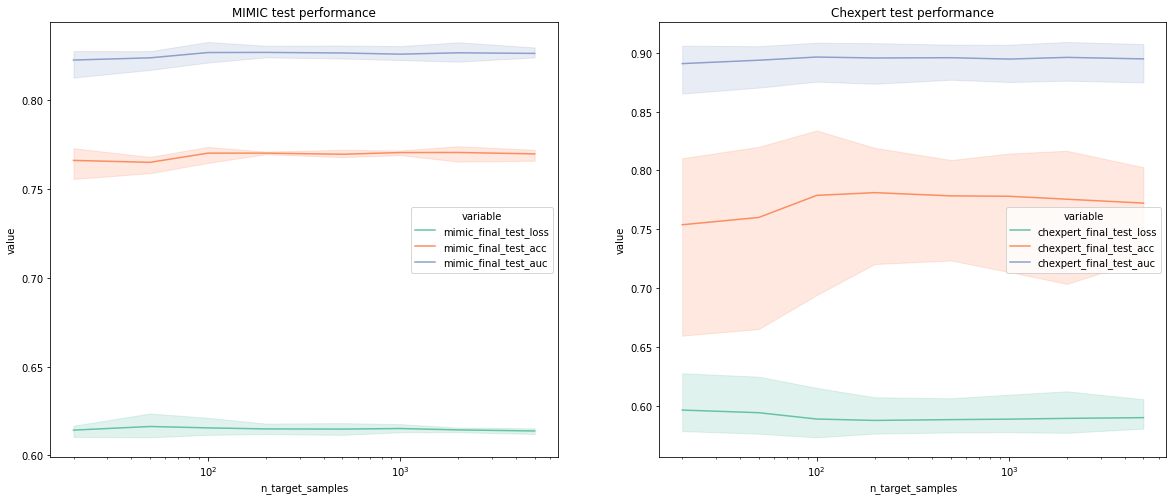

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
ax[0].set(xscale='log')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')
ax[1].set(xscale='log');

# Visualize training and validation losses for the two training phases

In [42]:
def plot_losses(df, phase='target', n_target_samples=20, loss_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{loss_type}_loss'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    losses = np.stack(stackable)

    avg_loss = np.mean(losses, axis=0)
    upper_ = avg_loss + np.std(losses, axis=0)
    lower_ = avg_loss - np.std(losses, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_loss, 'k--')
    ax.plot(losses.T)
    ax.legend(['average loss', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='upper right')

    ax.set_title(f'{loss_type} loss on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('BCE loss')


## 20 MIMIC samples

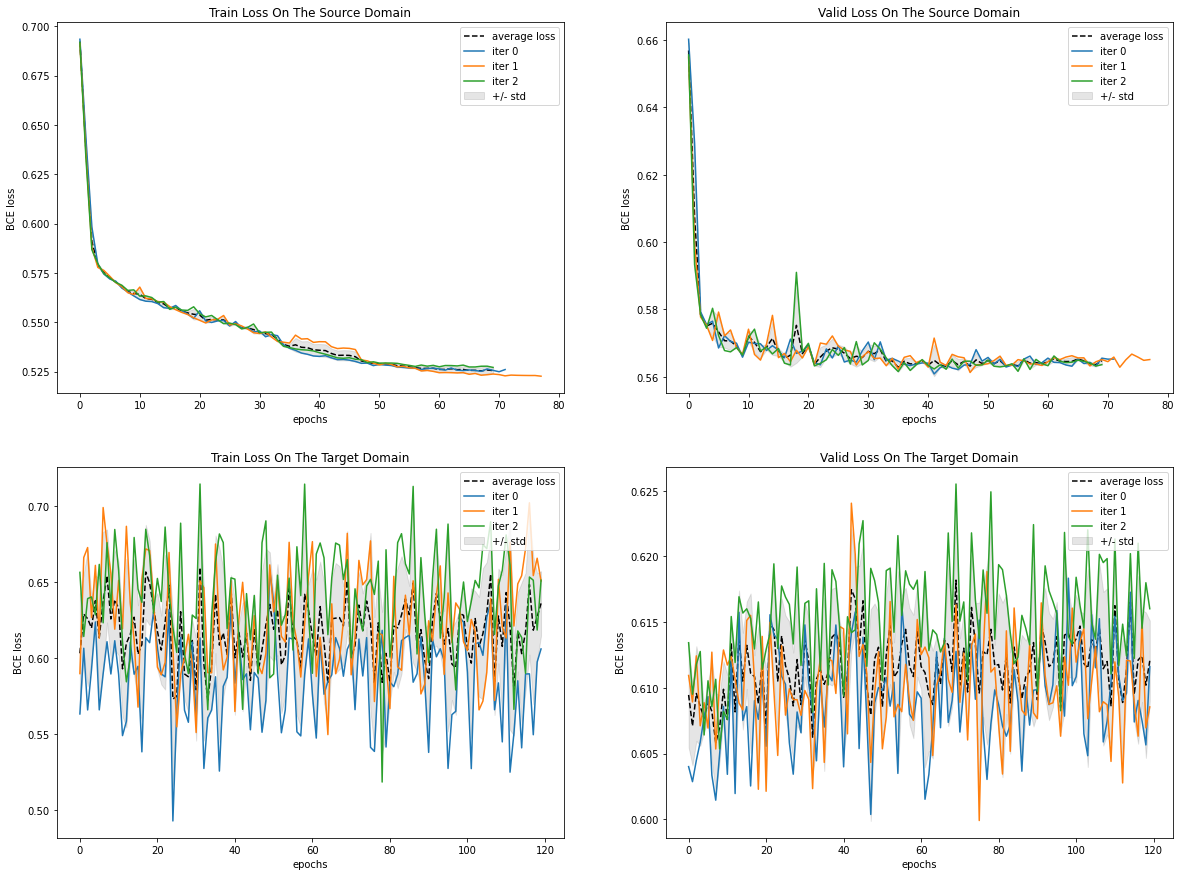

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

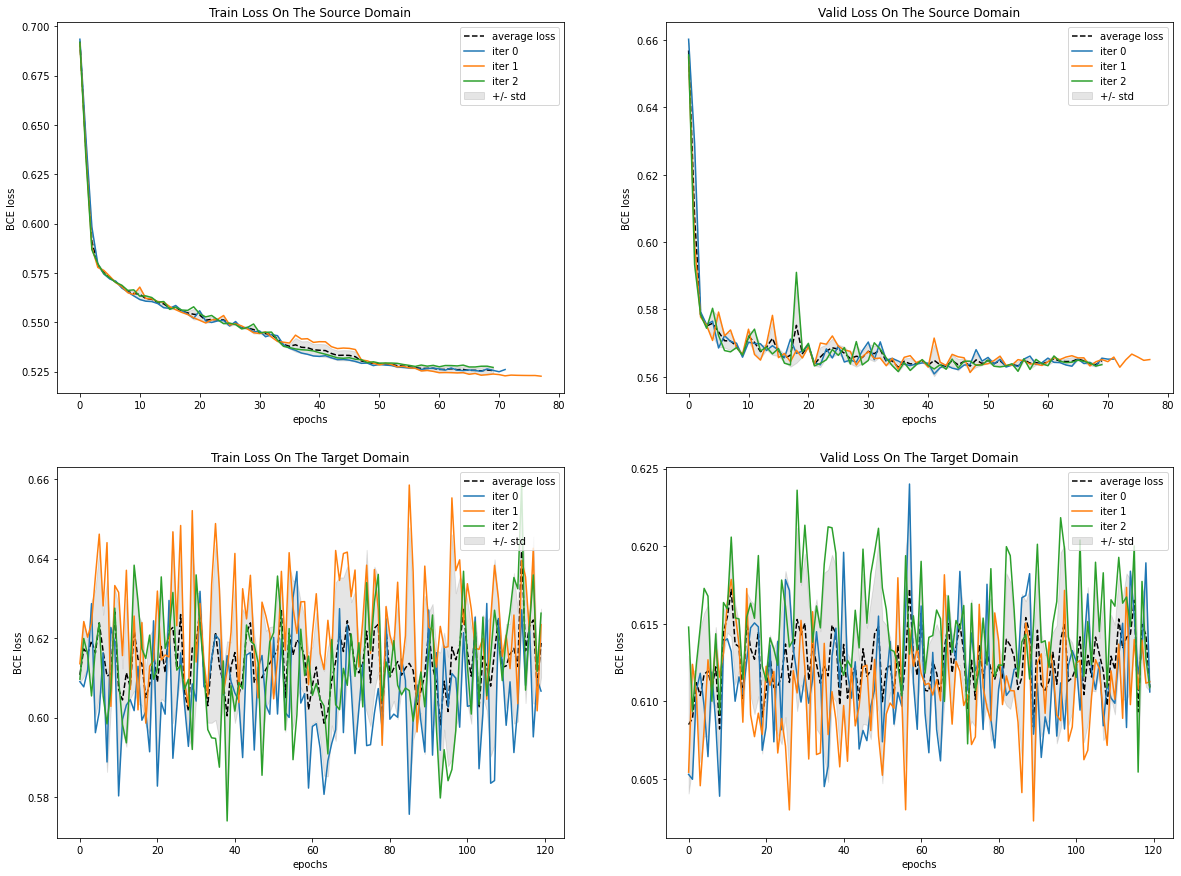

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

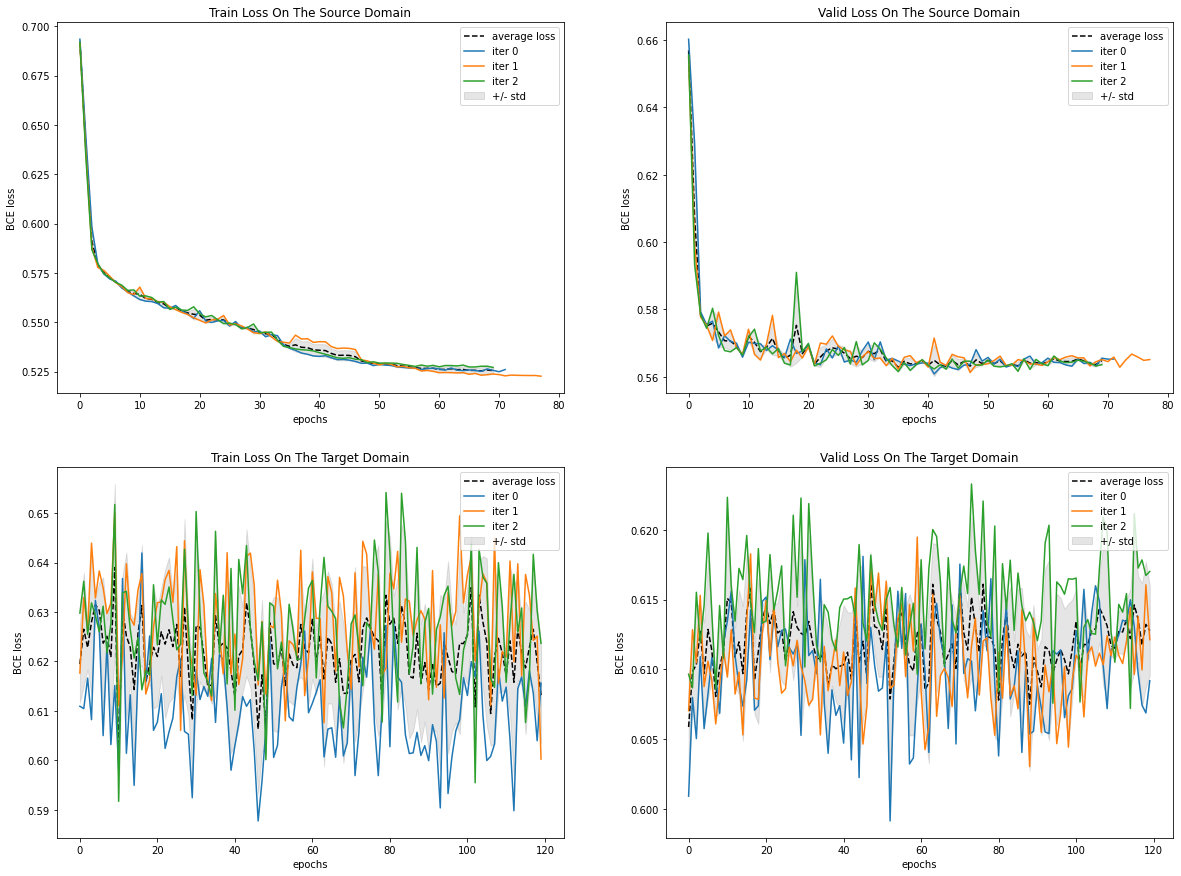

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

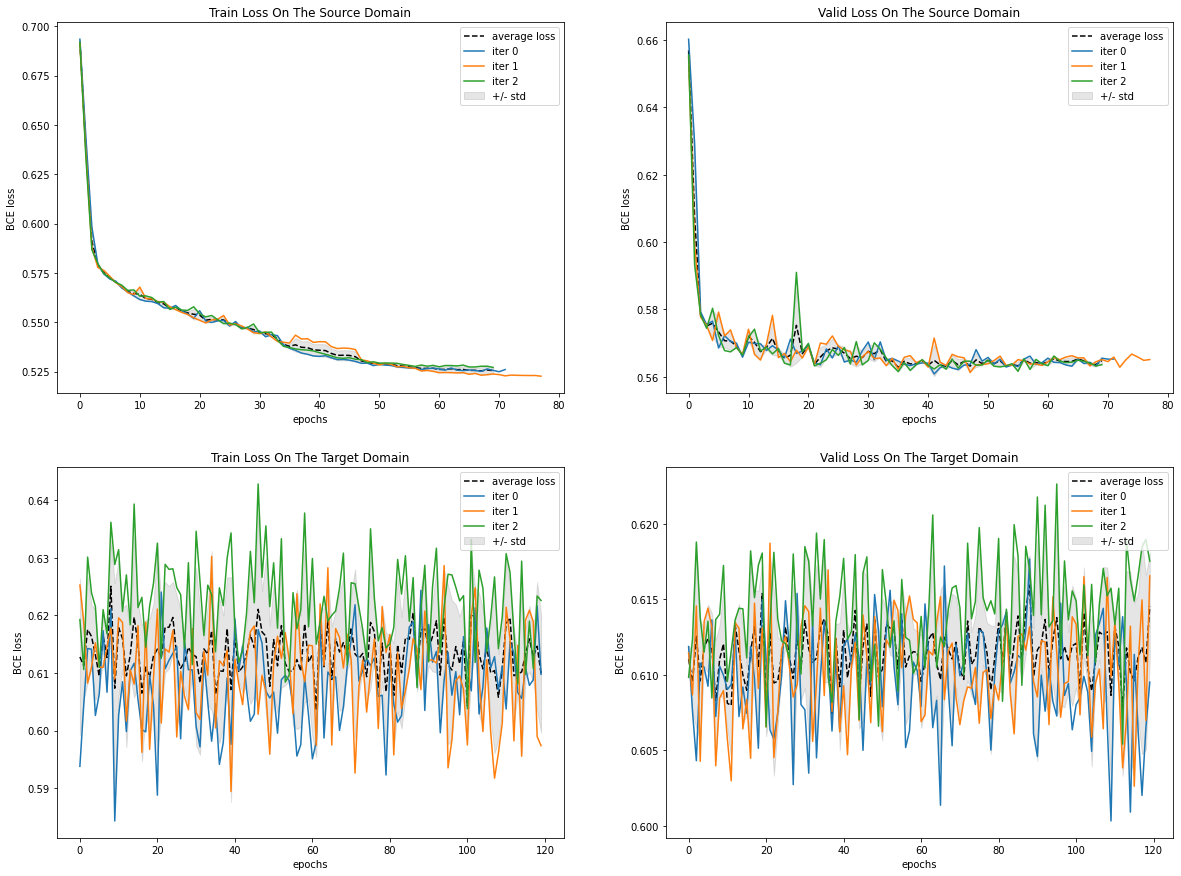

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

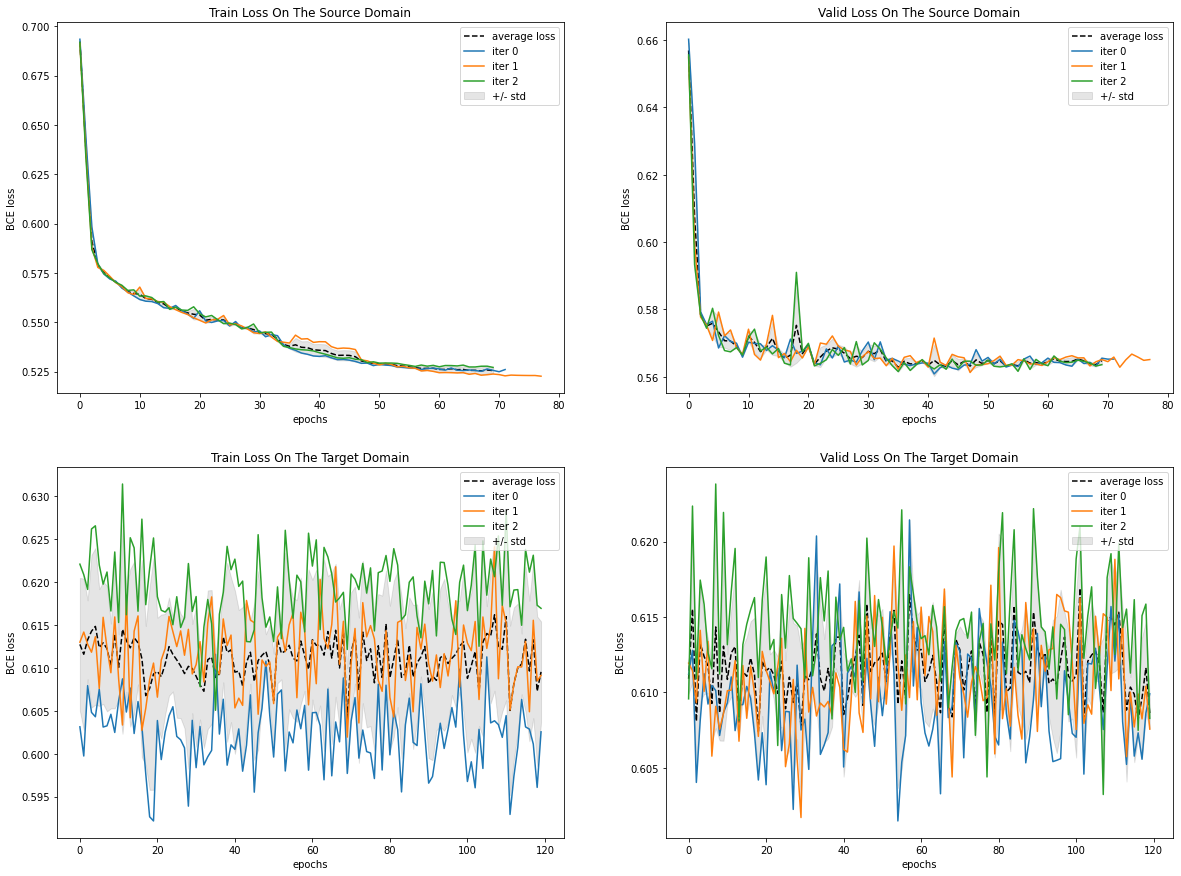

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

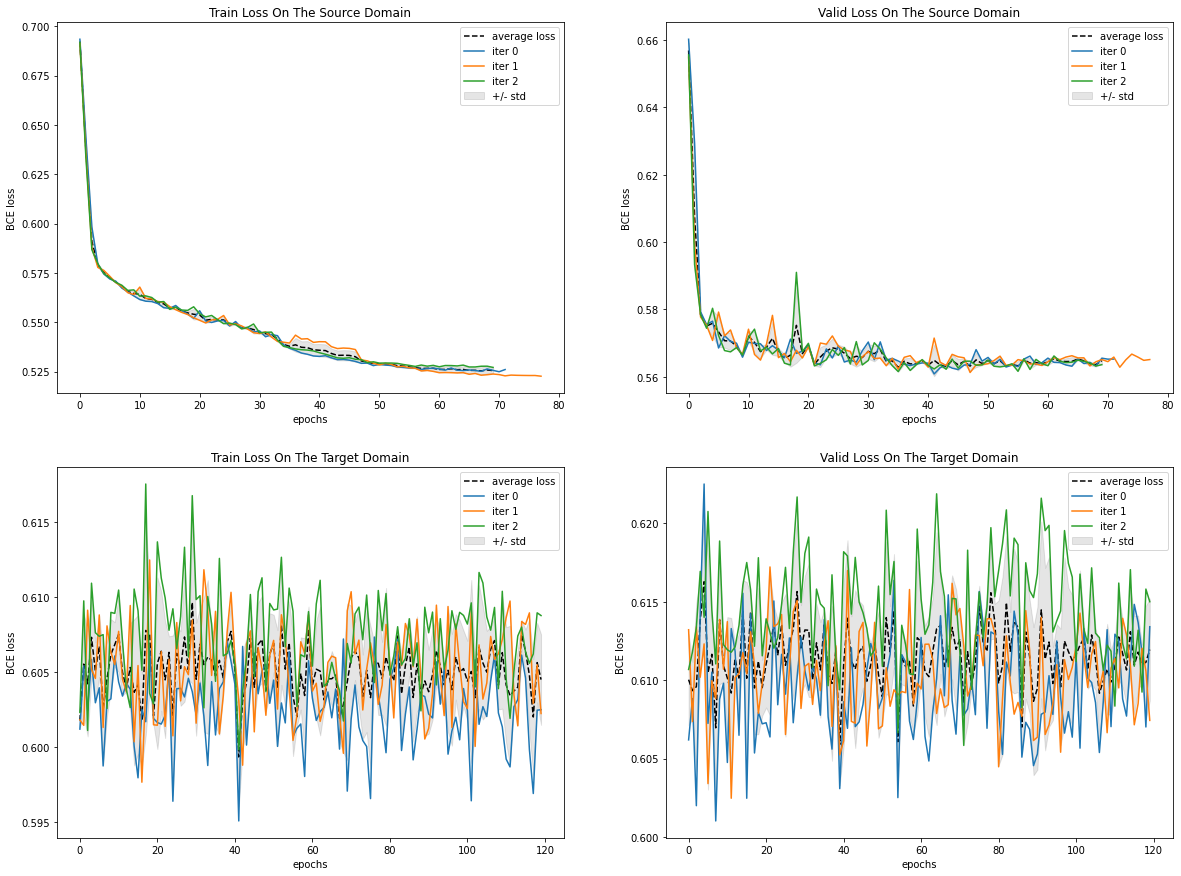

In [48]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_losses(model_meta, 'source', loss_type='train', ax=ax[0, 0])
plot_losses(model_meta, 'source', loss_type='valid', ax=ax[0, 1])
plot_losses(model_meta, 'target', n_target_samples, loss_type='train', ax=ax[1, 0])
plot_losses(model_meta, 'target', n_target_samples, loss_type='valid', ax=ax[1, 1])

# Visualize training and validation accuracies for the two training phases

In [49]:
def plot_accuracies(df, phase='target', n_target_samples=20, acc_type='train', ax=None):
   
    if phase == 'target':
        df = df[df['n_target_samples'] == n_target_samples].copy()
    subset_df = df[df['phase'] == phase].copy()
    key = f'{acc_type}_acc'
    max_len = max([len(ele) for ele in subset_df.loc[:, key].values])
    stackable = [np.pad(arr, (0, max_len - len(arr)), constant_values=np.nan) for arr in subset_df.loc[:, key].values]
    acc = np.stack(stackable)

    avg_acc = np.mean(acc, axis=0)
    upper_ = avg_acc + np.std(acc, axis=0)
    lower_ = avg_acc - np.std(acc, axis=0)
    x_ = np.arange(len(upper_))

    ax.fill_between(x_, lower_, upper_, color='k', alpha=0.1)
    ax.plot(avg_acc, 'k--')
    ax.plot(acc.T)
    ax.legend(['average accuracy', 'iter 0', 'iter 1', 'iter 2', '+/- std'], loc='lower right')

    ax.set_title(f'{acc_type} Accuracy on the {phase} domain'.title())
    ax.set_xlabel('epochs')
    ax.set_ylabel('Accuracy')


## 20 MIMIC samples

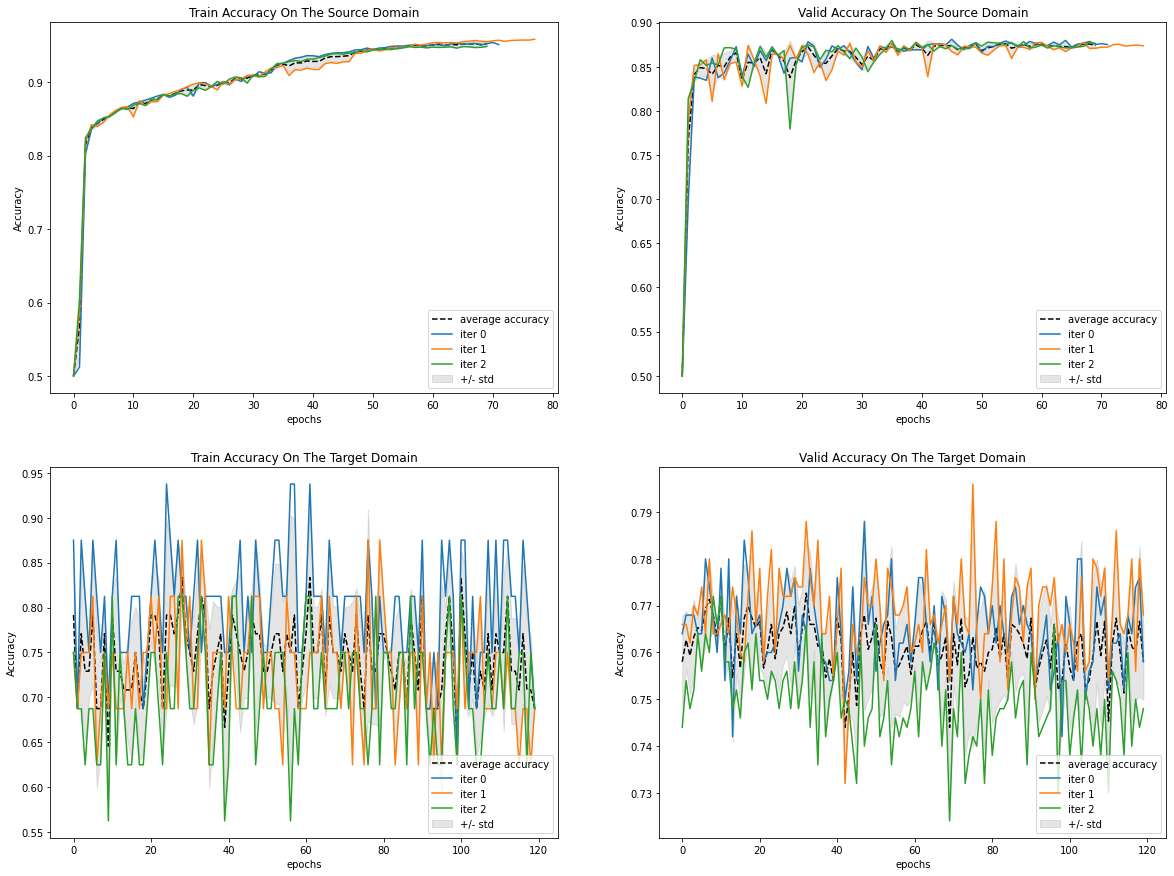

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 20

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 50 MIMIC samples

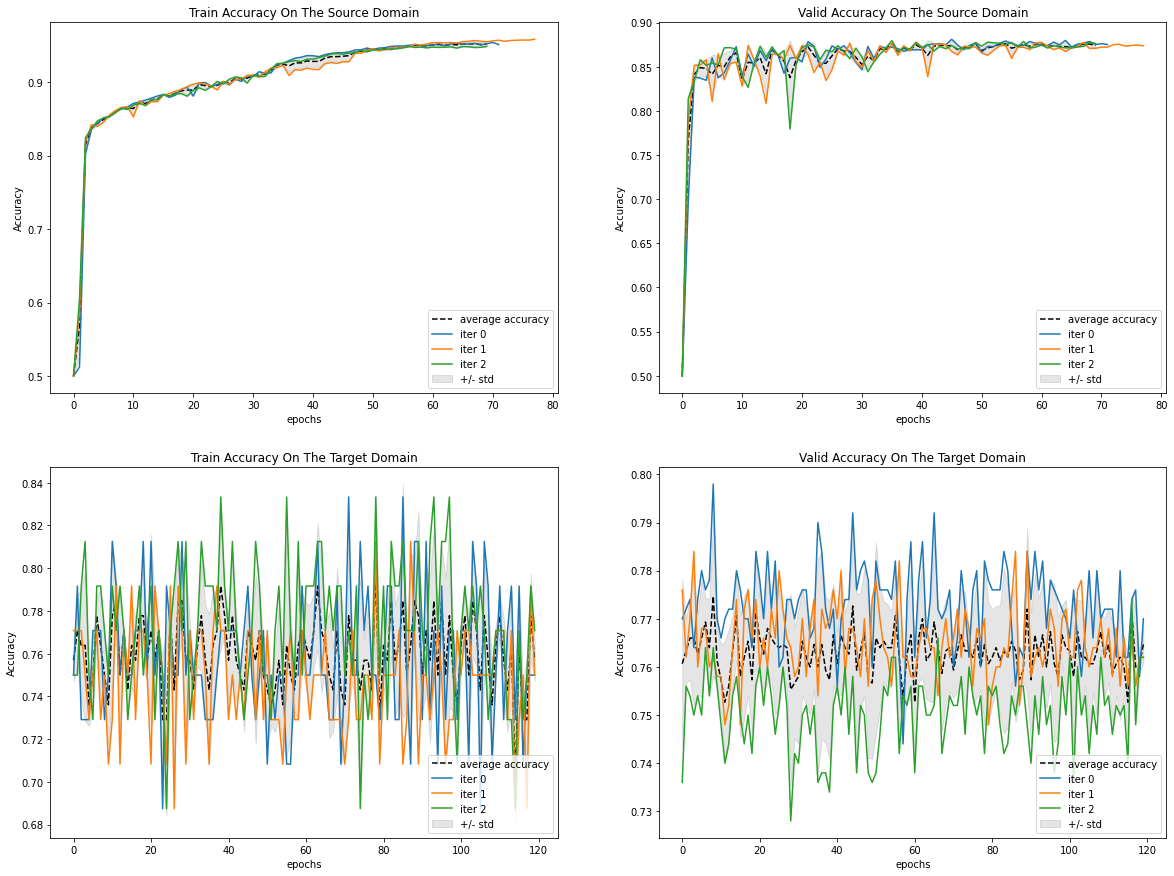

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 50

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 100 MIMIC samples

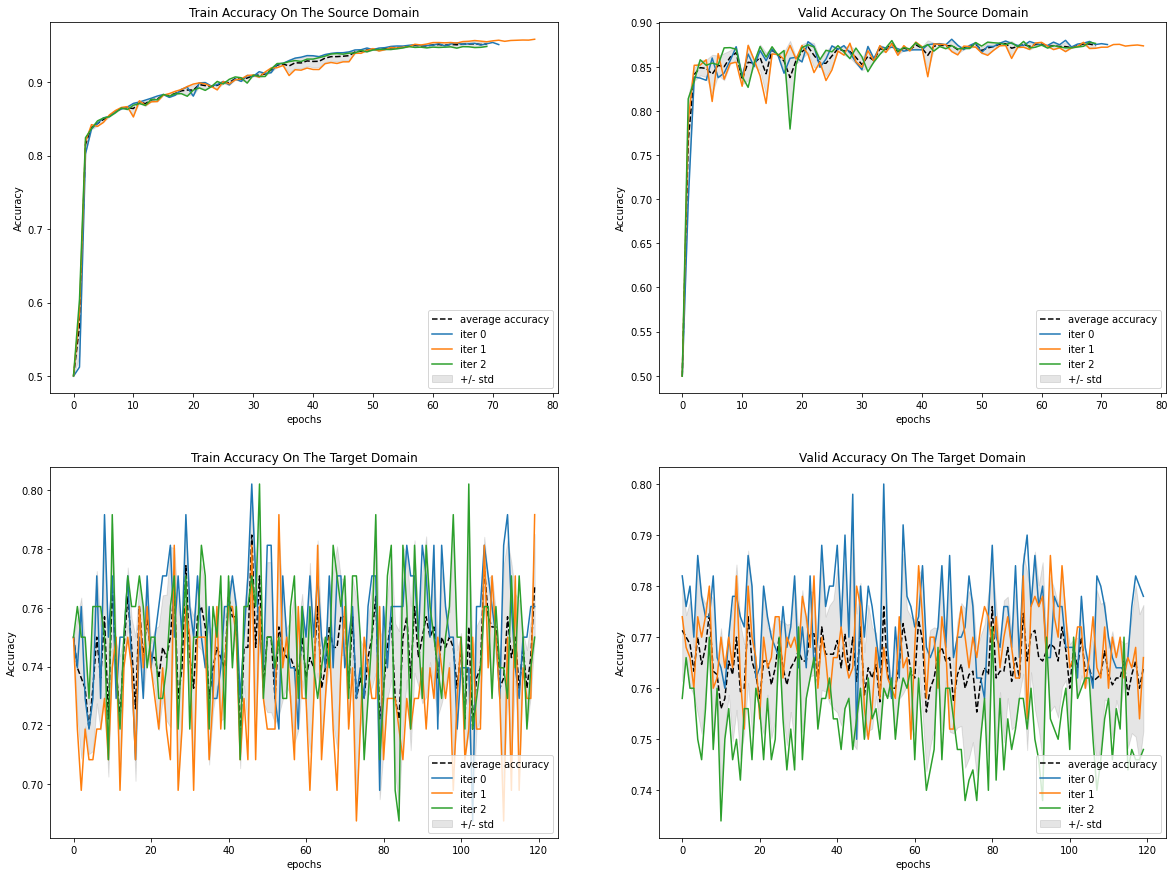

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 100

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 200 MIMIC samples

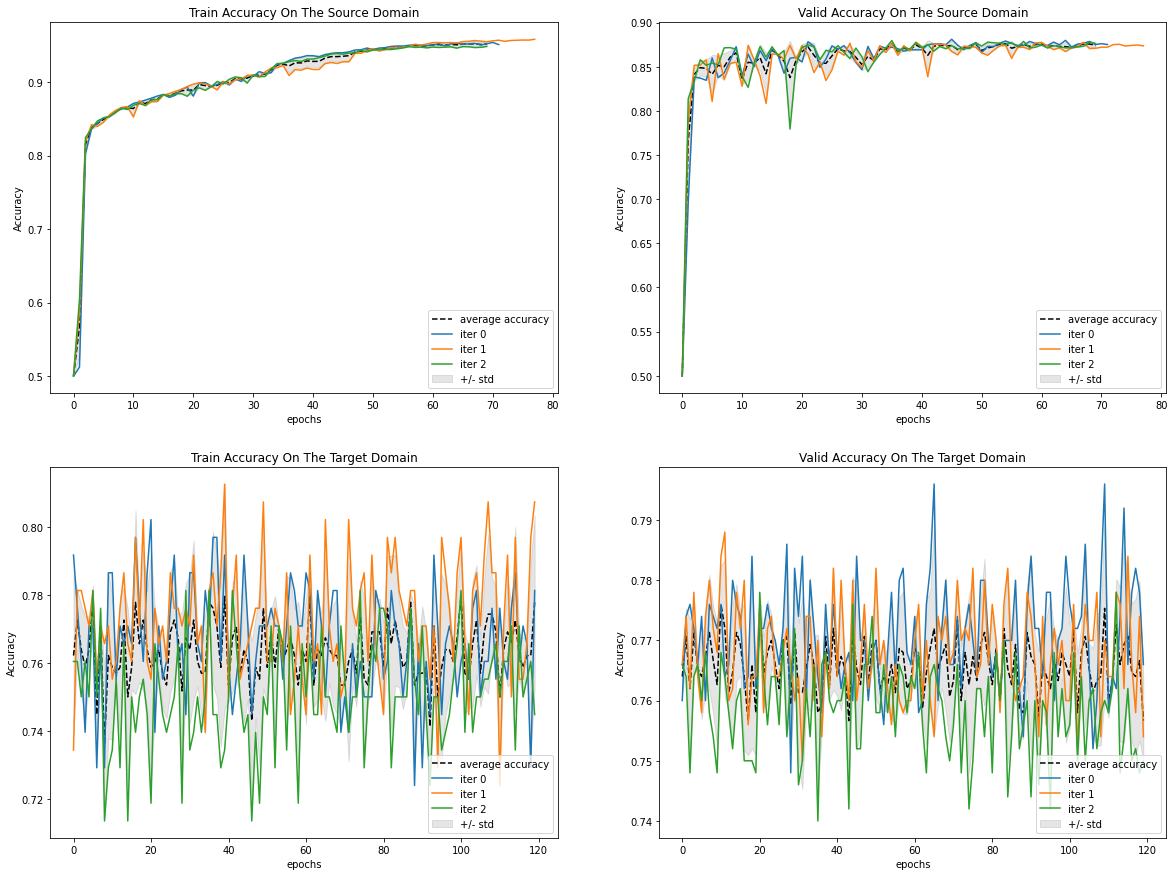

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 200

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 500 MIMIC samples

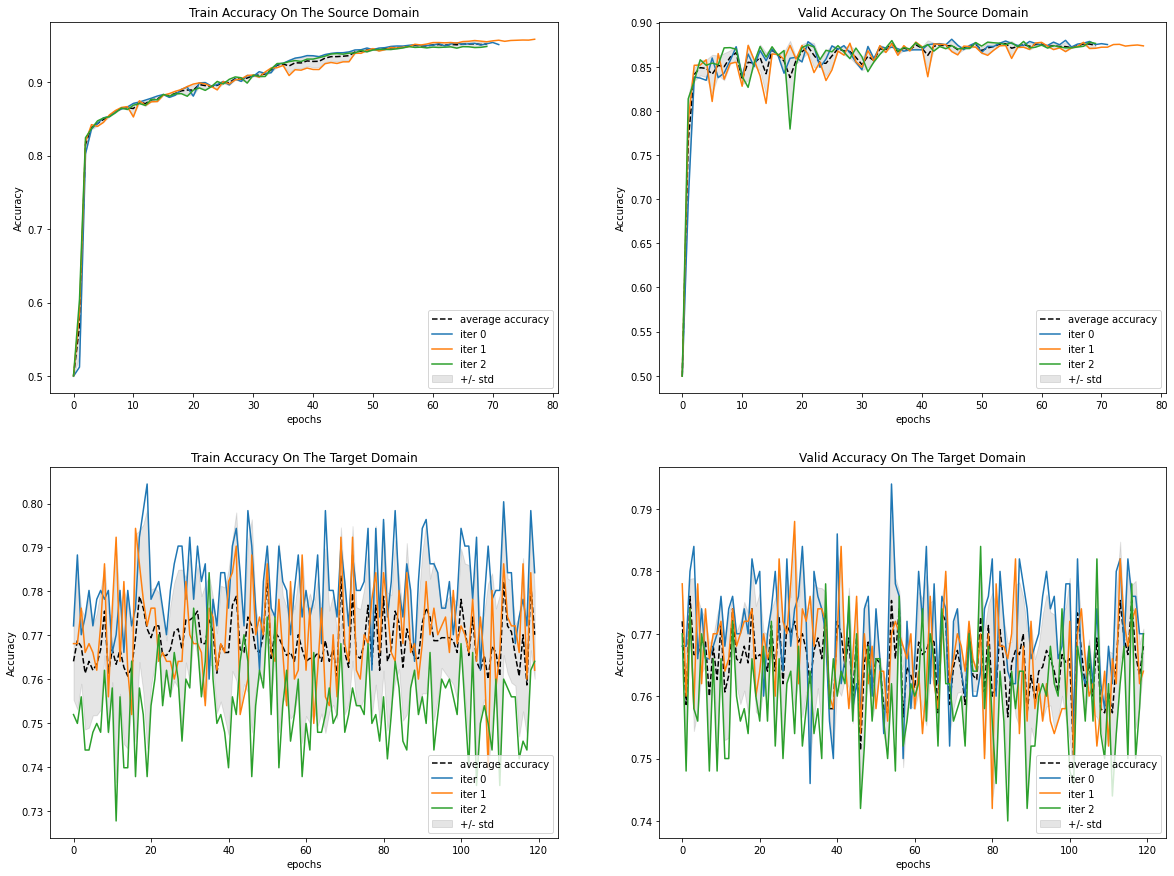

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 500

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

## 1000 MIMIC samples

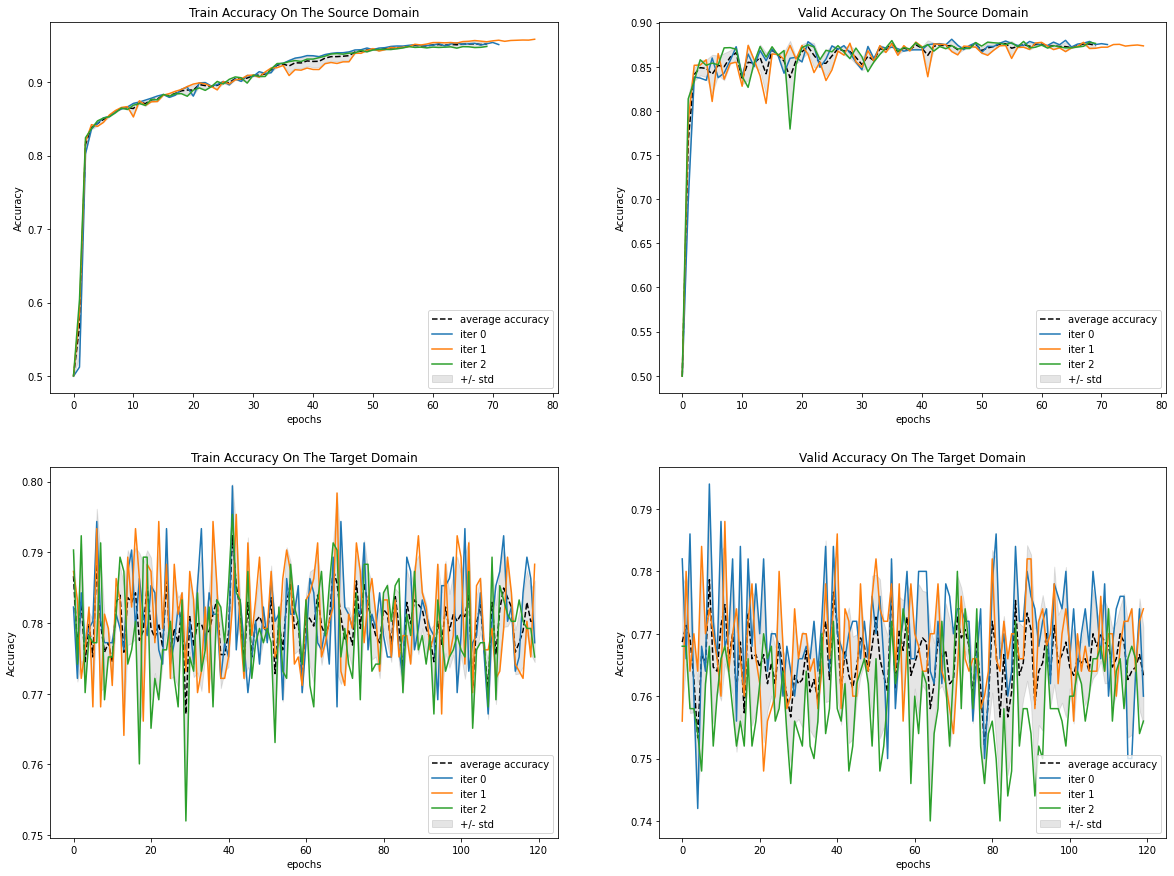

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

n_target_samples = 1000

plot_accuracies(model_meta, 'source', acc_type='train', ax=ax[0, 0])
plot_accuracies(model_meta, 'source', acc_type='valid', ax=ax[0, 1])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='train', ax=ax[1, 0])
plot_accuracies(model_meta, 'target', n_target_samples, acc_type='valid', ax=ax[1, 1])

# Summarize training metrics for trained models

In [58]:
target_meta = model_meta[model_meta['phase'] == 'target']

training_cols = ['final_train_loss', 'final_valid_loss', 'final_valid_acc', 'mimic_final_test_acc', 'chexpert_final_test_acc']

In [59]:
target_meta.groupby('n_target_samples').mean(numeric_only=True)[training_cols]

final_train_loss  final_valid_loss  final_valid_acc  \
n_target_samples                                                        
20                        0.635824          0.612062         0.758000   
50                        0.618766          0.610925         0.764667   
100                       0.613170          0.612780         0.764000   
200                       0.609919          0.614533         0.756667   
500                       0.609542          0.608578         0.768000   
1000                      0.604520          0.611949         0.763333   
2000                      0.604201          0.610319         0.770000   
5000                      0.609369          0.609585         0.769333   

                  mimic_final_test_acc  chexpert_final_test_acc  
n_target_samples                                                 
20                            0.766149                 0.753875  
50                            0.765062                 0.760083  
100                           0.770243                 0.778833  
200                           0.770243                 0.781167  
500                           0.769616                 0.778417  
1000                          0.770577                 0.778083  
2000                          0.770619                 0.775583  
5000                          0.769825                 0.772292